In [39]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../../slayerPytorch/src")

In [40]:
import slayerSNN as snn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dtw import dtw, accelerated_dtw
from numpy.linalg import norm
from joblib import Parallel, delayed
import torch
import copy
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

np.random.seed(1)
torch.manual_seed(1)

In [75]:
params = {
    "neuron": {
        "type": "SRMALPHA",
        "theta": 10, # 10
        "tauSr": 10.0,
        "tauRef": 1.0,
        "scaleRef": 2,
        "tauRho": 1,
        "scaleRho": 1,
    },
    "simulation": {"Ts": 1.0, "tSample": 400, "nSample": 1},
    "training": {
        "error": {
            "type": "NumSpikes",  # "NumSpikes" or "ProbSpikes"
            "probSlidingWin": 20,  # only valid for ProbSpikes
            "tgtSpikeRegion": {  # valid for NumSpikes and ProbSpikes
                "start": 0,
                "stop": 400,
            },
            "tgtSpikeCount": {True: 250, False: 60},
        }
    },
}
device = torch.device("cuda:1")

In [41]:
X_el = np.load('auxiliaries/electrodes.npy')
X_pac = np.load('auxiliaries/pac.npy')
Y = np.load('auxiliaries/labels.npy')
indices = np.arange(X_el.shape[0])

In [42]:
X_el = X_el.reshape(X_el.shape[0], X_el.shape[1], 1, 1, X_el.shape[-1])
X_pac = X_pac.reshape(X_pac.shape[0], 1, 1, 1, X_pac.shape[-1])
# Y = Y.reshape(Y.shape[0], Y.shape[1], 1, 1, Y.shape[-1])

In [43]:
def get_ohe(_Y):
    target_class = np.zeros([_Y.shape[0], 21])
    for i in range(target_class.shape[0]):
        target_class[i, int(_Y[i])] = 1
    return target_class

In [44]:
X_el_train, X_el_test, y_train, y_test, indx_train, indx_test = train_test_split(X_el, Y, indices, test_size=0.30, random_state=42, stratify=Y)

In [46]:
X_el_train = torch.FloatTensor(X_el_train)
y_train = torch.FloatTensor(y_train)
target_class_train = torch.FloatTensor(get_ohe(y_train).reshape(-1, 21, 1, 1, 1))
    
X_el_test = torch.FloatTensor(X_el_test)
y_test = torch.FloatTensor(y_test)
target_class_test= torch.FloatTensor(get_ohe(y_test).reshape(-1, 21, 1, 1, 1))

X_pac_train = torch.FloatTensor(X_pac[indx_train])
X_pac_test = torch.FloatTensor(X_pac[indx_test])

X_el_train.shape, y_train.shape, target_class_train.shape, X_pac_train.shape, X_pac_test.shape

(torch.Size([735, 19, 1, 1, 400]),
 torch.Size([735]),
 torch.Size([735, 21, 1, 1, 1]),
 torch.Size([735, 1, 1, 1, 8800]),
 torch.Size([315, 1, 1, 1, 8800]))

In [88]:
train_dataset = torch.utils.data.TensorDataset(X_el_train, X_pac_train, target_class_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=8)

test_dataset = torch.utils.data.TensorDataset(X_el_test, X_pac_test, target_class_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=8)

In [89]:
# define GCN

In [232]:
A = np.zeros([20,20])
A[1,[2]] = 1
A[2,[1,3,17]] = 1
A[3,[2,4,5]] = 1
A[4,[3,5]] = 1
A[5,[3,6,18]] = 1
A[6,[5]] = 1
A[7,[8,9]] = 1
A[8,[7,10]] = 1
A[9,[7,10]] = 1
A[10,[8,9,17]] = 1
A[11,[12]] = 1
A[12,[11,13,17]] = 1
A[13,[12,14,15]] = 1
A[14,[13,15]] = 1
A[15,[13,14,16]] = 1
A[16,[15]] = 1
A[17,[2,10,12]] = 1
A[18,[5,15,19]] = 1
A[19,[18]] = 1
A_ = A[1:, 1:]
A_.shape

(19, 19)

In [241]:
# gcn pre-computation
A = A_ + np.eye(A_.shape[0])
D = np.diag(np.sum(A,axis=1))
D_inv = np.linalg.inv(D)
D_inv_A = D_inv*A

# expand into correct dimension
D_inv_A = torch.FloatTensor(D_inv_A)
D_inv_A = D_inv_A.unsqueeze(-1)
D_inv_A = D_inv_A.expand(D_inv_A.shape[0], D_inv_A.shape[1], 400)

A = torch.FloatTensor(A)
A = A.unsqueeze(-1)
A = A.expand(A.shape[0], A.shape[1], 400)

In [242]:
D_inv_A.shape, A.shape

(torch.Size([19, 19, 400]), torch.Size([19, 19, 400]))

In [243]:
D_inv_A = D_inv_A.to(device)
A = A.to(device)

In [244]:
class GCNConv(torch.nn.Module):
    def __init__(self, netParams, in_channels, out_channels, normalize=True):
        super(GCNConv, self).__init__()
        self.slayer = snn.layer(netParams['neuron'], netParams['simulation'])
        self.weight_layer = self.slayer.dense(in_channels, out_channels)
        
        if normalize:
            self.const = D_inv_A
        else:
            self.const = A
        
    def forward(self, x):
        _batch_size = x.shape[0]
        
        # match batch size
        DA = self.const.unsqueeze(-1)
        DA = DA.expand(DA.shape[0], DA.shape[1],DA.shape[2], _batch_size)
        DA = DA.permute(3,0,1,2)
        
        # match pspX size
#         print(x.shape, DA.shape)
        pspX = x.squeeze(3)
#         print(pspX.shape, DA.shape)
#         print(pspX.permute(0,3,2,1).shape, DA.permute(0,3,2,1).shape)
        
        # get full multiplication
        DAX = torch.matmul(DA.permute(0,3,2,1),pspX.permute(0,3,2,1)) 
        DAX = DAX.permute(0,3,2,1).unsqueeze(3)
        
#         print('DAX', DAX.shape)
        return self.weight_layer(DAX)

In [255]:
class SlayerGCN(torch.nn.Module):
    def __init__(self, params, input_size, hidden_size, output_size):
        super(SlayerGCN, self).__init__()
        self.output_size = output_size
        self.slayer = snn.layer(params["neuron"], params["simulation"])
        
        self.gcn_layer1 = GCNConv(params, 1,2)
        
        self.fc1 = self.slayer.dense((1,19,2), hidden_size)
        self.fc2 = self.slayer.dense(hidden_size, output_size)

    def forward(self, input_el):
        
        # el data
        spike1 = self.slayer.spike(self.gcn_layer1(input_el))
#         print('GCN 1:', spike1.shape)
        #spike2 = self.slayer.spike(self.gcn_layer2(self.slayer.psp(spike1)))
        
#         print('GCN 2:', spike2.shape)
        
        spike3 = self.slayer.spike(self.slayer.psp(self.fc1(spike1)))
        spike3 = self.slayer.spike(self.slayer.psp(self.fc2(spike3)))
        
        return spike3

In [256]:
net = SlayerGCN(params, (1,19,4), 128, 21).to(device)

In [257]:
error = snn.loss(params).to(device)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001, weight_decay=0.5)

In [258]:
train_losses=[]
train_accs = []
test_losses = []
test_accs = []
for epoch in range(301):
    net.train()
    correct = 0
    num_samples = 0
    loss_train = 0
    for i, (tact_el, _, target, label) in enumerate(train_loader):
        
        tact_el = tact_el.to(device)
        tact_el = tact_el.permute(0,2,1,3,4)
        target = target.to(device)
        
        output = net.forward(tact_el)
        correct += torch.sum(snn.predict.getClass(output) == label).data.item()
        num_samples += len(label)
        loss = error.numSpikes(output, target)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
    if epoch%10 == 0:
        print('Epoch: ', epoch, ' --------------------------')
        print('Train loss:', loss_train/len(train_dataset))
        print('Train accuracy:', correct/len(train_dataset))
    train_accs.append(correct/len(train_dataset))
    train_losses.append(loss_train/len(train_dataset))
        
    net.eval()
    correct = 0
    num_samples = 0
    loss_test = 0
    with torch.no_grad():
        for i, (tact_el, _, target, label) in enumerate(test_loader):

            tact_el = tact_el.to(device)
            tact_el = tact_el.permute(0,2,1,3,4)
            target = target.to(device)

            output = net.forward(tact_el)
            correct += torch.sum(snn.predict.getClass(output) == label).data.item()
            num_samples += len(label)
            loss = error.numSpikes(output, target)
            loss_test += loss.item()
            
    if epoch%10 == 0:
        print('Test loss:', loss_test/len(test_dataset))
        print('Test accuracy:', correct/len(test_dataset))
    test_accs.append(correct/len(test_dataset))
    test_losses.append(loss_test/len(test_dataset))

Epoch:  0  --------------------------
Train loss: 129.56613894092794
Train accuracy: 0.06938775510204082
Test loss: 77.37267804827009
Test accuracy: 0.10476190476190476
Epoch:  10  --------------------------
Train loss: 37.972993355056865
Train accuracy: 0.6789115646258503
Test loss: 38.27283739362444
Test accuracy: 0.6634920634920635
Epoch:  20  --------------------------
Train loss: 31.695957583472843
Train accuracy: 0.7700680272108843
Test loss: 31.372579471648685
Test accuracy: 0.7682539682539683
Epoch:  30  --------------------------
Train loss: 29.1129710502365
Train accuracy: 0.8122448979591836
Test loss: 29.48492421952505
Test accuracy: 0.7936507936507936
Epoch:  40  --------------------------
Train loss: 27.492175002325148
Train accuracy: 0.8285714285714286
Test loss: 27.953928702218192
Test accuracy: 0.8126984126984127
Epoch:  50  --------------------------
Train loss: 25.970005279333414
Train accuracy: 0.854421768707483
Test loss: 27.092615278940354
Test accuracy: 0.86031746

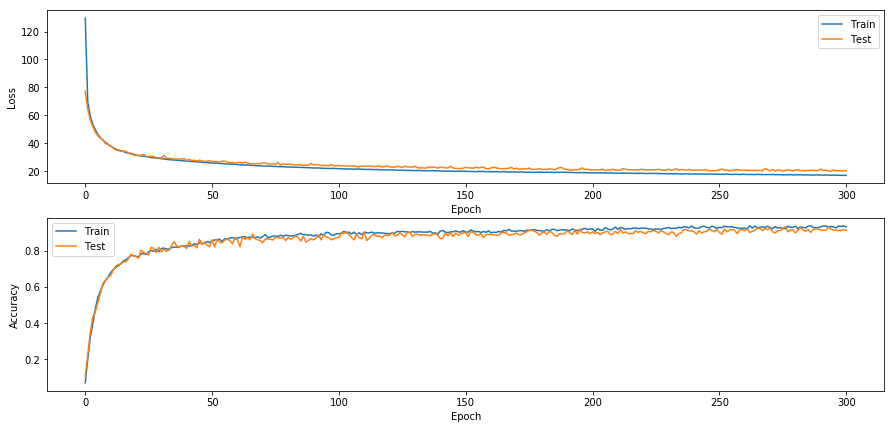

In [260]:
fig, ax = plt.subplots(2, figsize=(15,7))

ax[0].plot(train_losses)
ax[0].plot(test_losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(train_accs)
ax[1].plot(test_accs)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()

In [261]:
np.max(test_accs), np.max(train_accs)

(0.9333333333333333, 0.9387755102040817)